In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jy2040/lesion-detection-dataset

100% 4.20G/4.21G [00:43<00:00, 178MB/s]
100% 4.21G/4.21G [00:43<00:00, 105MB/s]


In [ ]:
!unzip /content/lesion-detection-dataset.zip -d /content/lesion-detection-datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/2.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/20.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/200.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/201.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/202.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/203.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/204.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/205.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/206.xml  
  inflating: /content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation/6/20

In [ ]:
import os
import csv
import cv2
import sys
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import xml.etree.ElementTree as ET

In [ ]:
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D
%matplotlib inline

In [ ]:
def get_filepaths(basepath, remove_ext=False):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
#         print("filename =", filename)
        if remove_ext is True:
            file_name, file_ext = filename.split(".")
#             print("file_name =", file_name)
#             print("file_ext =", file_ext)
            filepath = os.path.join(basepath, file_name)
            files.append(filepath)
            filenames.append(file_name)
        else:
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
            filenames.append(filename)
    return files, filenames
    
# TODO: Move above code into this function
def get_filepaths_videonum_dirs(basepath):
    videonum_frame_filepaths = []
    videonum_frame_filenames = []
    # loop each video number dir getting each frame filepath per video
    for videonum_dir in os.listdir(basepath):
        videonum_dirpath = os.path.join(basepath, videonum_dir)
        videonum_dirfilepaths, videonum_dirfilenames = get_filepaths(videonum_dirpath, remove_ext=True)
        videonum_frame_filepaths.extend(videonum_dirfilepaths)
        videonum_frame_filenames.extend(videonum_dirfilenames)
    return videonum_frame_filepaths, videonum_frame_filenames
    
def get_filepaths_videonum_dirs_xy(X_basepath, y_basepath):
    videonum_X_filepaths = []
    videonum_X_filenames = []
    videonum_y_filepaths = []
    videonum_y_filenames = []
    for videonum_X_dir, videonum_y_dir in zip(os.listdir(X_basepath), os.listdir(y_basepath)):
        videonum_X_dirpath = os.path.join(X_basepath, videonum_X_dir)
        videonum_y_dirpath = os.path.join(y_basepath, videonum_y_dir)
        videonum_y_dirfilepaths_tmp = []
        videonum_y_dirfilenames_tmp = []
        videonum_X_dirfilepaths, videonum_X_dirfilenames = get_filepaths(videonum_X_dirpath, remove_ext=True)
        videonum_y_dirfilepaths, videonum_y_dirfilenames = get_filepaths(videonum_y_dirpath, remove_ext=True)
#         print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#         print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        if len(videonum_X_dirfilenames) != len(videonum_y_dirfilenames):
            for y_i in range(len(videonum_y_dirfilenames)):
                if videonum_y_dirfilenames[y_i] in videonum_X_dirfilenames:
#                     print("videonum_y_dirfilenames[y_i] =", videonum_y_dirfilenames[y_i])
#                     print("is in videonum_X_dirfilenames = ", videonum_X_dirfilenames)
                    videonum_y_dirfilenames_tmp.append(videonum_y_dirfilenames[y_i] + ".xml")
                    videonum_y_dirfilepaths_tmp.append(videonum_y_dirfilepaths[y_i] + ".xml")
            videonum_y_filepaths.extend(videonum_y_dirfilepaths_tmp)
            videonum_y_filenames.extend(videonum_y_dirfilenames_tmp)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames_tmp) =", len(videonum_y_dirfilenames_tmp))
        else:
            videonum_y_dirfilepaths = [filepath + ".xml" for filepath in videonum_y_dirfilepaths]
            videonum_y_dirfilenames = [filename + ".xml" for filename in videonum_y_dirfilenames]
            videonum_y_filepaths.extend(videonum_y_dirfilepaths)
            videonum_y_filenames.extend(videonum_y_dirfilenames)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        videonum_X_dirfilepaths = [filepath + ".jpg" for filepath in videonum_X_dirfilepaths]
        videonum_X_dirfilenames = [filename + ".jpg" for filename in videonum_X_dirfilenames]
        videonum_X_filepaths.extend(videonum_X_dirfilepaths)
        videonum_X_filenames.extend(videonum_X_dirfilenames)
    return videonum_X_filepaths, videonum_X_filenames, videonum_y_filepaths, videonum_y_filenames
    
def read_img(img_path):
    # (height, width, 3)
    image = cv2.imread(img_path)
    return image

def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

# normalizes image pixel values betwen -0.5 and 0.5
def normalize_images(images):
    norm_images = []
    for image in tqdm(images):
        norm_img = (image/255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

def normalize_image(image):
    norm_img = (image/255.0) - 0.5
    return norm_img

def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_images(image_group, size):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path)
        resized_img = cv2.resize(image, (size, size))
        images.append(resized_img)
    return images

def create_image_label_groups(image_paths, image_labels, batch_size=32):
    # Divide image paths and image labels into groups of BATCH_SIZE
    image_groups = list()
    label_groups = list()
    
    for idx in range(0, len(image_paths), batch_size):
        image_batch = list()
        for index in range(idx, idx + batch_size):
            image_batch.append(image_paths[index % len(image_paths)])
        image_groups.append(image_batch)
            
    for idx in range(0, len(image_labels), batch_size):
        for index in range(idx, idx + batch_size):
            label_groups.append(image_labels[index % len(image_labels)])
    
    return image_groups, label_groups
    
def create_image_batch(image_group):
    # get the max image shape from the batch of images
    max_shape = tuple()
    image_shapes = list()
    
    for channel in range(3):
        for image in image_group:
            image_shapes.append(image.shape[channel])
        
def change_extension(img_file, file_type):
    p = Path(img_file)
    return p.rename(p.with_suffix(file_type))
    
# loads image from filepath using opencv
def get_image(basepath, filepath):
    # read images
    source_path = filepath
    # extract filename from filepath using split and check platform
    if sys.platform == 'win32':
        filename = source_path.split("\\")[-1]
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        filename = source_path.split("/")[-1]
    # add filename to end of path to PolypSet dir, so platform isn't an issue
    img_path_on_fs = basepath + filename
    # load image using opencv
    image = cv2.imread(img_path_on_fs)
    return image


def plot_sample(X, y, index):
    plt.figure(figsize = (30,4))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

In [ ]:
train_y_basepath = "/content/lesion-detection-datasets/polyps/PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [ ]:
train_y_polyp_names = get_xml_label_names(train_y_filepaths)

100%|██████████| 28773/28773 [00:12<00:00, 2284.18it/s]


In [ ]:
print(len(train_y_polyp_names))
print(train_y_polyp_names[0])
print(train_y_polyp_names[1])

28773
adenomatous
adenomatous


In [ ]:
label_enc = LabelEncoder()

In [ ]:
# Label Encode y_train polyp names
train_y = label_enc.fit_transform(train_y_polyp_names)

In [ ]:
classes = ['Not Specified', 'adenomatous', 'hyperplastic']

In [ ]:
train_X_basepath = "/content/lesion-detection-datasets/polyps/PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [ ]:
train_X_filepaths1 = train_X_filepaths[0:len(train_X_filepaths)//2]
train_X_filepaths2 = train_X_filepaths[len(train_X_filepaths)//2:]
print(len(train_X_filepaths1),len(train_X_filepaths2))

14386 14387


In [ ]:
train_X_images = get_images(train_X_filepaths,120)

100%|██████████| 28773/28773 [02:11<00:00, 219.38it/s]


In [ ]:
X_train = np.array(train_X_images)

In [ ]:
X_train = X_train/255

In [ ]:
valid_X_basepath = "/content/lesion-detection-datasets/polyps/PolypsSet/val2019/Image"
valid_y_basepath = "/content/lesion-detection-datasets/polyps/PolypsSet/val2019/Annotation"

# Problem is that the valid set has more labels than there are images, so need to make them equal
valid_X_filepaths, valid_X_filenames, valid_y_filepaths, valid_y_filenames= get_filepaths_videonum_dirs_xy(valid_X_basepath, valid_y_basepath)

In [ ]:
print("valid_X_filepaths =", len(valid_X_filepaths))
print("valid_y_filepaths =", len(valid_y_filepaths))

valid_X_filepaths = 4254
valid_y_filepaths = 4254


In [ ]:
assert len(valid_X_filepaths) == len(valid_y_filepaths)

In [ ]:
valid_X_images = get_images(valid_X_filepaths, 120)

100%|██████████| 4254/4254 [00:24<00:00, 173.72it/s]


In [ ]:
X_valid = np.array(valid_X_images)

In [ ]:
X_valid.shape

(4254, 120, 120, 3)

In [ ]:
# So now we can apply normalize to each img in X_train & X_valid
X_valid = X_valid / 255

In [ ]:
valid_y_polyp_names = get_xml_label_names(valid_y_filepaths)

100%|██████████| 4254/4254 [00:01<00:00, 2893.36it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


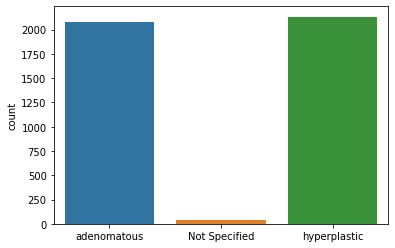

In [ ]:
sns.countplot(valid_y_polyp_names)

In [ ]:
valid_y = label_enc.fit_transform(valid_y_polyp_names)

In [ ]:
valid_y

array([1, 1, 1, ..., 1, 1, 1])

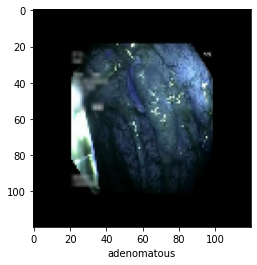

In [ ]:
plot_sample(X_valid, valid_y, 0)

In [ ]:
test_X_basepath = "/content/lesion-detection-datasets/polyps/PolypsSet/test2019/Image"
test_y_basepath = "/content/lesion-detection-datasets/polyps/PolypsSet/test2019/Annotation"

# Potential Problem is that the test set has more labels than there are images, so need to make them equal
test_X_filepaths, test_X_filenames, test_y_filepaths, test_y_filenames= get_filepaths_videonum_dirs_xy(test_X_basepath, test_y_basepath)


In [ ]:
print("test_X_filepaths =", len(test_X_filepaths))
print("test_y_filepaths =", len(test_y_filepaths))

test_X_filepaths = 4872
test_y_filepaths = 4872


In [ ]:
assert len(test_X_filepaths) == len(test_y_filepaths)

In [ ]:
test_X_images = get_images(test_X_filepaths, 120)

100%|██████████| 4872/4872 [00:25<00:00, 192.68it/s]


In [ ]:
X_test = np.array(test_X_images)

In [ ]:
X_test.shape

(4872, 120, 120, 3)

In [ ]:
# So now we can apply normalize to each img in X_train & X_test
X_test = X_test / 255

In [ ]:
test_y_polyp_names = get_xml_label_names(test_y_filepaths)

100%|██████████| 4872/4872 [00:01<00:00, 2808.17it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


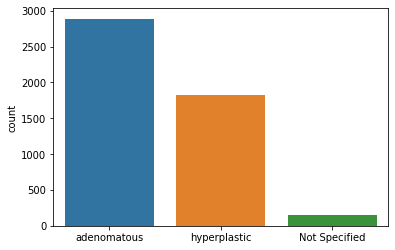

In [ ]:
sns.countplot(test_y_polyp_names)

In [ ]:
test_y = label_enc.fit_transform(test_y_polyp_names)

In [ ]:
test_y

array([1, 1, 1, ..., 2, 2, 2])

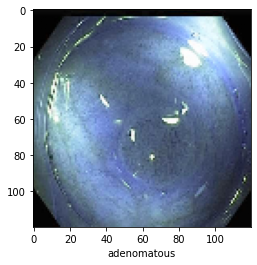

In [ ]:
plot_sample(X_test, test_y, 0)

In [ ]:
# ann = models.Sequential([
#     # flatten layer 2D 32x32 RGB img to array vector
#     layers.Flatten(input_shape=(120,120,3)),
#     # Deep dense layer with 3000 neurons and relu activation
#     layers.Dense(3000, activation="relu"),
#     # Deep dense layer with 1000 neurons and relu activation
#     layers.Dense(1000, activation="relu"),
#     # Last dense layers has 3 neurons since we have 10 categories
#     layers.Dense(3, activation="sigmoid")
# ])

In [ ]:
# we are using sparse_categorical_crossentropy since our train_y is 
# label encoded
# ann.compile(optimizer="SGD",
#             loss="sparse_categorical_crossentropy",
#             metrics=["accuracy"])

In [ ]:
# ann.fit(X_train, train_y, epochs=5)

In [ ]:
model = Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation = 'relu'),
    keras.layers.Dense(256,activation = 'relu'),
    keras.layers.Dense(128,activation = 'relu'),
    keras.layers.Dense(3,activation = 'softmax')
])

# optimizers tried -> adam, SGD
# opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics= ['accuracy'])

# model.fit(X_train,train_y,epochs=2,batch_size = 32)


In [ ]:
model.fit(X_test,test_y,epochs=2,batch_size = 32)

In [ ]:
# model.evaluate(X_valid,valid_y)

In [ ]:
model = Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3, padding='same', activation=tf.keras.layers.ReLU(), input_shape=[120,120,3]),
    keras.layers.Conv2D(filters=32,kernel_size=3, padding="same", activation=tf.keras.layers.ReLU()),
    keras.layers.MaxPooling2D(pool_size=2,strides=2, padding='valid'),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation=tf.keras.layers.ReLU()),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation=tf.keras.layers.ReLU()),
    keras.layers.MaxPooling2D(pool_size=2,strides=2,padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation = tf.keras.layers.ReLU()),
    keras.layers.Dense(3,activation = 'softmax')
])

opt = tf.keras.optimizers.Nadam()
model.compile(optimizer=opt,
             loss = 'sparse_categorical_crossentropy',
             metrics= ['accuracy'])

# history = model.fit(training_images,np.array(labels),epochs=10,batch_size = 32, validation_data= (testing_images, np.array(test_labels)))

In [ ]:
model.fit(X_train,train_y,epochs=5,batch_size = 32, validation_data = (X_valid, valid_y))

Epoch 1/5
900/900 [==============================] - 302s 334ms/step - loss: 0.8879 - accuracy: 0.4872 - val_loss: 0.7997 - val_accuracy: 0.4892
Epoch 2/5
900/900 [==============================] - 297s 330ms/step - loss: 0.8795 - accuracy: 0.4932 - val_loss: 0.7753 - val_accuracy: 0.4892
Epoch 3/5
900/900 [==============================] - 312s 346ms/step - loss: 0.8793 - accuracy: 0.4927 - val_loss: 0.7779 - val_accuracy: 0.4892
Epoch 4/5
900/900 [==============================] - 338s 375ms/step - loss: 0.8806 - accuracy: 0.4935 - val_loss: 0.7682 - val_accuracy: 0.4892
Epoch 5/5
900/900 [==============================] - 313s 348ms/step - loss: 0.8788 - accuracy: 0.4930 - val_loss: 0.7907 - val_accuracy: 0.4892


In [ ]:
model.evaluate(X_test,test_y)

153/153 [==============================] - 5s 35ms/step - loss: 0.8177 - accuracy: 0.5932


[0.8177032470703125, 0.593185544013977]

In [ ]:
# del model

In [ ]:
# model.save('model_lesion_detection_1.h5')  